# Explanation

This notebook reads results from WandB and plots the Pareto frontiers for different experiments.
1. specify the project and entity name in cell below
2. specify plotting options in the most bottom cell ('experiment_specs')
3. if desired, specify save directory in the most bottom cell (save_dir = r'...')

In [1]:
# Specify the project and entity
project_name = 'yourWandbProjectName'
entity_name = 'yourWandbEnityName'

# Load runs froms Wandb

In [ ]:
import wandb
import os
from itertools import product
from paretoset import paretoset  # Library for Pareto frontiers
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Initialize the API object
api = wandb.Api()

# Fetch all runs in the project
runs = api.runs(f'{entity_name}/{project_name}')
run_dataframes = []

for run in runs:
    df = run.history()
    df['run_id'] = run.id  # Add the run ID to the DataFrame for tracking
    run_dataframes.append(df)

# Combine and group all run histories into a single DataFrame
all_run_data = pd.concat(run_dataframes, ignore_index=True)
all_run_data.groupby('run_id').agg({'_step': 'max'})

,_step
run_id,
037p7eko,40
0egqoio5,40
0eq39x5q,79
0jwvqg9l,40
0rmqqjbm,80
...,...
z5efzfx2,46
zazzolw4,60
zm1352r7,83


In [ ]:
# Apply early stopping. Optionally: first smooth the composite validation loss (the lower the ema_alpha, the more smoothing. For no smoothing ,set ema_alpha=1)
def apply_early_stopping(df, unique_id, loss_col, fixed_step=None, ema_alpha=1.0, min_step=15):

    # Ensure there are no missing values in the loss column
    if df[loss_col].isnull().any():
        print(f"Warning: Missing values found in '{loss_col}'. Handling missing values.")
        df[loss_col].fillna(float('inf'), inplace=True)

    # Filter the DataFrame to include only steps above min_step
    df = df[df['_step'] >= min_step]

    if fixed_step is not None:
        # Select the observation with the specified _step for each run_id
        all_run_data = df[df['_step'] == fixed_step]
    else:
        # Apply EMA smoothing to the loss column
        df['smoothed_loss'] = df.groupby(unique_id)[loss_col].transform(lambda x: x.ewm(alpha=ema_alpha).mean())

        # Plot the original and smoothed loss for a single run (example: first run)
        example_run_id = df[unique_id].iloc[0]
        example_run_data = df[df[unique_id] == example_run_id]

        # Early stopping: select the observation with the lowest composite loss for each run_id
        all_run_data = df.loc[df.groupby(unique_id)['smoothed_loss'].idxmin()]

    return all_run_data

df = apply_early_stopping(all_run_data, 'run_id', 'composite_loss_val', fixed_step=None, ema_alpha=0.99)

# Analysis and plot

In [5]:
plt.style.use('science')

# Configuration for plotting
plotting = {
    1: False, 2: True,
    'nonPareto': True, 'plotLambda': False, 'connectDots': True, 'filter_plot_xaxis': 0.0
}


# Filter DataFrame based on recall (set coeff to 0.0 for no filtering)
def filter_by_recall(df, coeff=0.0, recall_column='val_recall'):
    recall_tau_reference = df[df['lam'] == 0.00][recall_column].values[0]
    return df[df[recall_column] > coeff * recall_tau_reference]


# Load DataFrame based on experiment specifications
def load_dataframe(experiment_specs, df):
    filtered_df = df[
        (df['bias_ratio'] == experiment_specs['bias_ratio']) &
        (df['bin_width'] == experiment_specs['bin_width']) &
        (df['pct_a'] == experiment_specs['pct_a'])
        ]
    return filter_by_recall(filtered_df, experiment_specs['tau_recall_coeff'], experiment_specs['tau_recall_column'])


# Plot Pareto frontiers
def plot_pareto_frontier(group, xAxis, yAxis):
    mask = paretoset(group[[xAxis, yAxis]], sense=["min", "max"])
    return group[mask]


# Generate the legend labels based on experiment configurations
def generate_legend_label(name, local_reg):
    legend_labels = {
        1: 'dp', 2: 'wasserstein'
    }
    fair_reg_label = legend_labels.get(name, f'fair_reg={name}')
    local_reg_label = 'Local reg.' if local_reg == 1 else 'Global reg.'
    return f'{local_reg_label}'


# Plot data into the subplot axis
def plot_data(df, plotting, experiment_specs, ax, xAxis, yAxis, show_legend=False):
    # Sort and group the DataFrame by 'fair_reg' and 'local_reg'
    df = df.sort_values(['fair_reg', 'local_reg', xAxis, yAxis])
    groups = df.groupby(['fair_reg', 'local_reg'])
    colors_local, colors_global = plt.cm.tab10, plt.cm.tab20

    for idx, (name, group) in enumerate(groups):
        if plotting.get(name[0], False):
            color = colors_local(idx) if name[1] == 1 else colors_global(idx)
            label = generate_legend_label(name[0], name[1])

            # Filter x-axis if necessary
            if plotting['filter_plot_xaxis']:
                group = group[group[xAxis] > plotting['filter_plot_xaxis']]

            # Extract Pareto frontier
            pareto_df = plot_pareto_frontier(group, xAxis, yAxis)

            # Plot non-Pareto points
            if plotting['nonPareto']:
                ax.plot(group[xAxis], group[yAxis], marker='o', linestyle='None', alpha=0.5, color=color, markersize=2)

            # Add lambda values if enabled
            if plotting['plotLambda']:
                for _, row in group.iterrows():
                    ax.text(row[xAxis], row[yAxis], f'{row["lam"]:.2f}', fontsize=8, alpha=0.5, ha='right',
                            color='cyan')

            # Plot Pareto points
            if plotting['connectDots']:
                ax.plot(pareto_df[xAxis], pareto_df[yAxis], marker='o', linestyle='-', label=label, color=color,
                        markersize=2)
            else:
                ax.plot(pareto_df[xAxis], pareto_df[yAxis], marker='o', linestyle='None', label=label, color=color,
                        markersize=2)

    # Highlight observations where 'lam == 0' and 'local_reg == 0' with a red star
    biased_model_df = df[(df['lam'] == 0) & (df['local_reg'] == 0)]
    ax.plot(biased_model_df[xAxis], biased_model_df[yAxis], marker='*', linestyle='None', color='red', markersize=5,
            label='Biased model')

    # Rename axes
    xAxis_label = r'$\text{ABCC}_{\tau}$' if xAxis == 'test_abcc_local' else (
        r'$\text{ABPC}_{\tau}$' if xAxis == 'test_abpc_local' else xAxis)
    yAxis_label = r'$\text{AUC-PR}_{\tau}$' if yAxis == 'test_auc_pr_local_tau' else yAxis

    ax.set_xlabel(xAxis_label)
    ax.set_ylabel(yAxis_label)

    ax.set_title(fr'$\tau$: {experiment_specs["pct_a"]}')

    if show_legend:
        ax.legend(fontsize=6)

test_abpc_local vs. test_auc_pr_local_tau


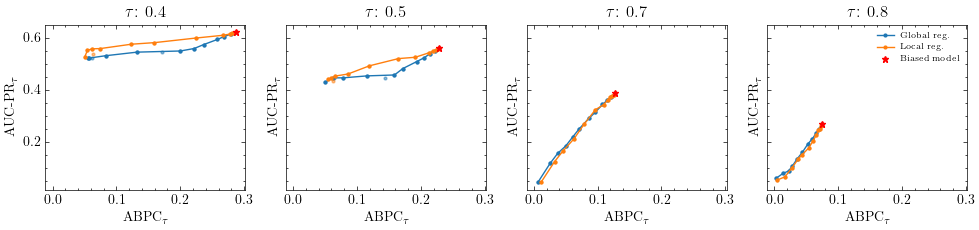

test_abcc_local vs. test_auc_pr_local_tau


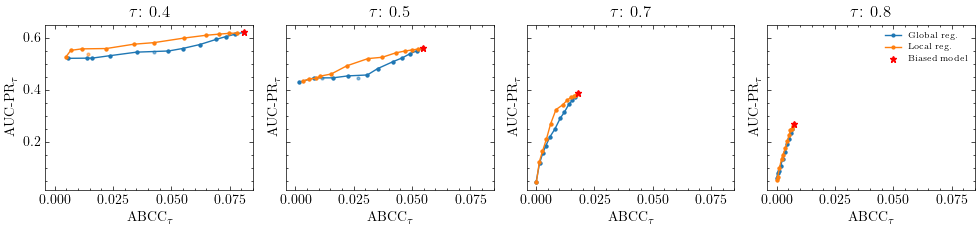

In [8]:
# Plotting specifications
experiment_specs = {
    'bias_ratio': [0.00],           # only relevant for TelecomChurn
    'pct_a': [0.4,0.5,0.7,0.8],     # This is \tau
}

# Axes to be used in the plots
xAxes = ['test_abpc_local','test_abcc_local']
yAxes = ['test_auc_pr_local_tau']

# Iterate over combinations of axes
for xAxis in xAxes:
    for yAxis in yAxes:
        # Create grid of subplots
        num_rows, num_cols = len(experiment_specs['bias_ratio']), len(experiment_specs['pct_a'])
        if num_rows == 1 and num_cols == 1:
            fig, ax = plt.subplots(figsize=(2.5 * num_cols, 2.5 * num_rows), sharex=True, sharey=True)
            axes = [ax]
        else:
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(2.5 * num_cols, 2.5* num_rows), sharex=True, sharey=True)
            axes = axes.ravel()

        # Determine the index for the top-right panel (lowest bias_ratio, highest pct_a)
        sorted_combinations = sorted(product(experiment_specs['bias_ratio'], experiment_specs['pct_a']), key=lambda x: (x[0], -x[1]))
        legend_index = len(sorted_combinations) - 1

        # Iterate over combinations of bias_rate and pct_a, and plot into the corresponding axis
        for idx, (bias_ratio, pct_a) in enumerate(product(experiment_specs['bias_ratio'], experiment_specs['pct_a'])):
            current_specs = {**experiment_specs, 'bias_ratio': bias_ratio, 'pct_a': pct_a}
            _df = load_dataframe(current_specs, df)
            show_legend = (idx == 3)  # Show legend only for the top-right subplot
            plot_data(_df, plotting, current_specs, axes[idx], xAxis, yAxis, show_legend=show_legend)

        # Adjust layout and display the grid
        plt.tight_layout()
        
        print(f'{xAxis} vs. {yAxis}')
        
        #
        save_dir = r'...'
        os.makedirs(save_dir, exist_ok=True)
        filename = f"adult_{xAxis}-{yAxis}0.4,0.5,0.7,0.8.pdf"
        
        save_path = os.path.join(save_dir, filename)
        #plt.savefig(save_path, dpi=300, format='pdf')  # Save as PDF in save_dir

        plt.show()